In [60]:
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [61]:
class GoldToken:
    def __init__(self, initial_supply):
        # Initialize allocations
        self.allocations = {
            'airdrop': 0.1 * initial_supply,
            'TGE': 0.1 * initial_supply,
            'central_bank_reserve': 0.08 * initial_supply,
            'treasury': 0.3 * initial_supply,
            'marketing': 0.05 * initial_supply,
            'community_pool': 0.25 * initial_supply,
            'team': 0.1 * initial_supply,
            'Redeemed': 0
        }
        self.circulating_supply = self.allocations['airdrop'] + self.allocations['TGE'] + self.allocations['central_bank_reserve']
        self.total_supply = initial_supply
        self.locked_supply = sum(self.allocations.values()) - self.circulating_supply
        self.gold_minted = 0  # Initialize minted gold
        self.vesting_schedules = {
            'treasury': {'total_duration': 48, 'cliff': 0, 'release_per_epoch': (0.3 * initial_supply / 48), 'circulating': 0},
            'marketing': {'total_duration': 12, 'cliff': 0, 'release_per_epoch': (0.05 * initial_supply / 12), 'circulating': 0},
            'community_pool': {'total_duration': 48, 'cliff': 0, 'release_per_epoch': (0.25 * initial_supply / 48), 'circulating': 0},
            'team': {'total_duration': 36, 'cliff': 6, 'release_per_epoch': (0.1 * initial_supply / 36), 'circulating': 0},
        }
        # Set circulating supply for vesting allocations to zero
        for allocation in self.vesting_schedules:
            self.allocations[allocation] = 0

    def mint(self, amount):
        self.allocations['central_bank_reserve'] += amount
        self.circulating_supply += amount # Update circulating supply
        self.total_supply += amount # Update total supply
        self.gold_minted += amount  # Update minted gold

    def update_vesting(self, epoch):
        for allocation, schedule in self.vesting_schedules.items():
            if epoch >= schedule['cliff']:
                if 'circulating' not in schedule:  # Initialize if not present
                    schedule['circulating'] = 0
                total_vested = schedule['release_per_epoch']
                if epoch <= (schedule['cliff'] + schedule['total_duration']):
                    schedule['circulating'] += total_vested
                    self.circulating_supply += total_vested
                    self.total_supply =+ total_vested
                    self.locked_supply -= total_vested
                    self.allocations[allocation] += total_vested
                # Ensure that we do not exceed the allocation after the vesting period
                self.allocations[allocation] = min(self.allocations[allocation], schedule['total_duration'] * schedule['release_per_epoch'])

    def get_circulating_supply(self):
        return self.circulating_supply

    def get_all_allocations(self):
        return self.allocations

In [62]:
class Game:
    def __init__(self, central_bank, initial_difficulty=1):
        self.central_bank = central_bank
        self.total_xp_generated = 0
        self.difficulty = initial_difficulty

    def generate_xp(self, base_xp):
        actual_xp = base_xp / self.difficulty
        self.total_xp_generated += actual_xp
        return actual_xp

    def update_game_difficulty_based_on_pid(self):
        # Get the PID output from the central bank
        pid_output = self.central_bank.get_pid_output()
        # If the PID output is positive, it suggests a need to increase the difficulty
        # to reduce XP gain and thus gold redemption.
        if pid_output > 0:
            self.increase_difficulty()
        # If the PID output is negative, consider decreasing the difficulty
        # to encourage more XP gain and gold redemption.
        elif pid_output < 0:
            self.decrease_difficulty()

    def increase_difficulty(self):
        self.difficulty += self.difficulty * 0.1  # Increase difficulty by 10%

    def decrease_difficulty(self):
        self.difficulty = max(1, self.difficulty - self.difficulty * 0.1)  # Ensure it doesn't go below 1

In [63]:
class CentralBank:
    def __init__(self, gold_token, kp=1, ki=2, kd=3, xp_to_gold_rate=1):
        self.gold_token = gold_token
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.previous_error = 0
        self.integral = 0
        self.derivative = 0
        self.xp_to_gold_rate = xp_to_gold_rate
        self.xp_redeemed_history = [0] * 10  # Track the last 10 epochs of XP redeemed

    def update_xp_redeemed_history(self, xp_redeemed):
        self.xp_redeemed_history.pop(0)  # Remove the oldest epoch
        self.xp_redeemed_history.append(xp_redeemed)  # Add the latest epoch

    def calculate_target_reserve(self):
        # The target reserve is the sum of XP redeemed over the last 10 epochs, converted to gold
        target_reserve = sum(self.xp_redeemed_history) * self.xp_to_gold_rate
        return target_reserve

    def calculate_reserve_error(self):
        current_reserve = self.gold_token.allocations['central_bank_reserve']
        target_reserve = self.calculate_target_reserve()
        reserve_error = target_reserve - current_reserve
        return reserve_error

    def update_pid_controller(self):
        reserve_error = self.calculate_reserve_error()
        self.integral += reserve_error
        derivative = reserve_error - self.previous_error
        pid_output = self.kp * reserve_error + self.ki * self.integral + self.kd * derivative
        self.previous_error = reserve_error
        return pid_output

    def get_pid_output(self):
        return self.update_pid_controller()

    def check_and_adjust_gold_supply(self):
        pid_output = self.update_pid_controller()
        # If PID output is positive, mint more gold to the reserve to maintain the target ratio
        if pid_output > 0:
            self.mint_gold_to_reserve(pid_output)
        # If PID output is negative, it indicates excess reserve, which may require other mechanisms to handle

    def mint_gold_to_reserve(self, amount):
        self.gold_token.mint(amount)

    def redeem_xp_for_gold(self, xp_amount):
        self.update_xp_redeemed_history(xp_amount)
        gold_amount = xp_amount * self.xp_to_gold_rate
        self.gold_token.allocations['central_bank_reserve'] -= gold_amount
        self.gold_token.allocations['Redeemed'] += gold_amount
        # Check and mint gold if the reserve is below the minimum threshold after redemption
        self.ensure_minimum_reserve()

    def ensure_minimum_reserve(self):
        # Calculate the minimum reserve threshold as the sum of the last 5 epochs of XP redeemed
        minimum_reserve_threshold = sum(self.xp_redeemed_history[-5:]) * self.xp_to_gold_rate
        if self.gold_token.allocations['central_bank_reserve'] < minimum_reserve_threshold:
            # Mint enough gold to meet the minimum reserve threshold
            amount_needed = minimum_reserve_threshold - self.gold_token.allocations['central_bank_reserve']
            self.mint_gold_to_reserve(amount_needed)

    def check_and_adjust_gold_supply(self):
        pid_output = self.update_pid_controller()
        if pid_output > 0:
            self.mint_gold_to_reserve(pid_output)
        self.ensure_minimum_reserve()  # Ensure minimum reserve after PID adjustment

In [76]:
class XPRedeemFactor:
    def __init__(self):
        self.last_factor = 1.0  # Start with a neutral factor of 1
        self.mean_factor = 1.0  # Baseline mean factor
        self.std_dev_factor = 0.25  # Standard deviation for variability
        self.min_factor = 0.8  # Minimum bound for the factor
        self.max_factor = 1.3  # Maximum bound for the factor
        self.adjustment_rate = 0.1  # Rate at which to return to the mean factor

    def xp_redeem_random_factor(self):
        # If the last factor is significantly different from the mean, adjust it closer to the mean
        if self.last_factor > self.mean_factor:
            adjusted_mean = max(self.mean_factor, self.last_factor - self.adjustment_rate)
        elif self.last_factor < self.mean_factor:
            adjusted_mean = min(self.mean_factor, self.last_factor + self.adjustment_rate)
        else:
            adjusted_mean = self.mean_factor

        # Generate a new factor based on the adjusted mean
        factor = random.normalvariate(adjusted_mean, self.std_dev_factor)

        # Apply bounds to ensure the factor remains realistic
        factor = max(self.min_factor, min(factor, self.max_factor))

        # Update the last factor for the next call
        self.last_factor = factor

        return factor

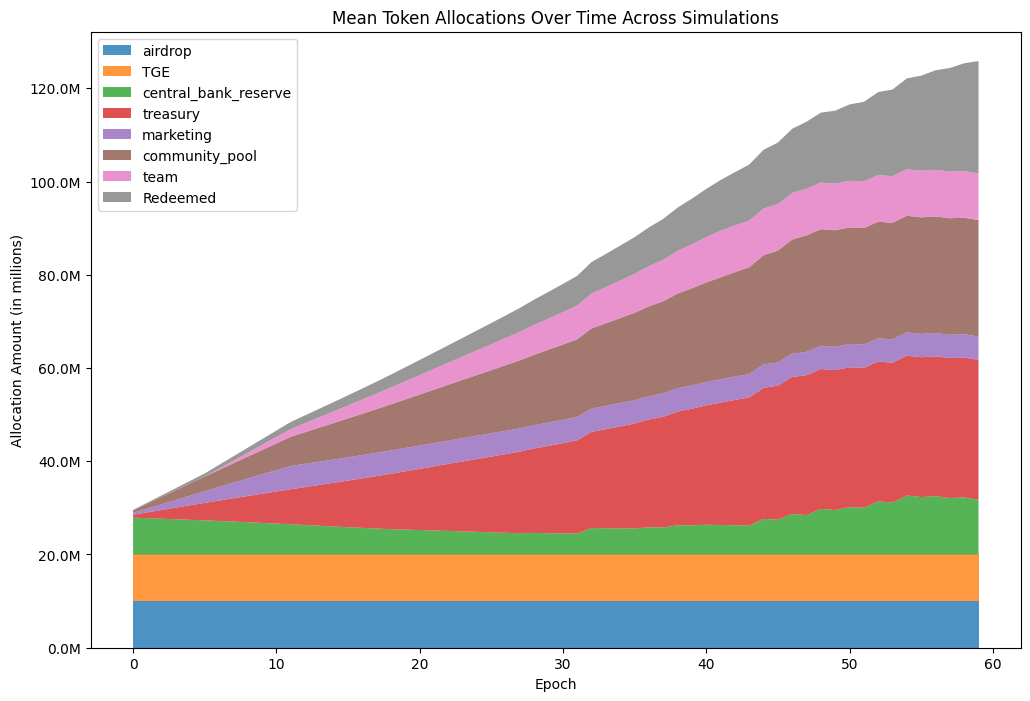

In [80]:
num_simulations = 100  # Number of simulations to run
epochs = 60
initial_xp_redeemed = 100000
xp_factor_simulator = XPRedeemFactor()

# Function to format the y-axis ticks as millions
def millions_formatter(x, pos):
    return f'{x / 1e6}M'

# Initialize a structure to hold simulation results
simulation_results = {
    'airdrop': [],
    'TGE': [],
    'central_bank_reserve': [],
    'treasury': [],
    'marketing': [],
    'community_pool': [],
    'team': [],
    'Redeemed': []
}

for simulation in range(num_simulations):
    # Reset or reinitialize classes for each simulation
    gold_token = GoldToken(100000000)
    central_bank = CentralBank(gold_token)
    game = Game(central_bank)
    xp_redeemed = initial_xp_redeemed

    # Temporary storage for this simulation's data
    temp_allocation_history = {key: [] for key in simulation_results.keys()}

    for epoch in range(epochs):
        gold_token.update_vesting(epoch)
        xp_redeemed *= xp_factor_simulator.xp_redeem_random_factor()
        central_bank.redeem_xp_for_gold(xp_redeemed)

        if epoch % 2 == 0:
            central_bank.check_and_adjust_gold_supply()
        game.update_game_difficulty_based_on_pid()

        # Store allocations for this epoch
        for key in temp_allocation_history:
            temp_allocation_history[key].append(gold_token.allocations[key])

    # After each simulation, append this simulation's data to simulation_results
    for key in simulation_results:
        if len(simulation_results[key]) == 0:
            simulation_results[key] = np.array(temp_allocation_history[key])
        else:
            simulation_results[key] += np.array(temp_allocation_history[key])

# Calculate mean of simulations
for key in simulation_results:
    simulation_results[key] /= num_simulations

# Plotting the mean allocation data over time
plt.figure(figsize=(12, 8))
data = np.array(list(simulation_results.values()))

# Stackplot
plt.stackplot(range(epochs), *data, labels=simulation_results.keys(), alpha=0.8)

# Formatting y-axis to display values in millions with 'M' suffix
formatter = FuncFormatter(millions_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Plot configuration
plt.title('Mean Token Allocations Over Time Across Simulations')
plt.xlabel('Epoch')
plt.ylabel('Allocation Amount (in millions)')
plt.legend(loc='upper left')
plt.show()